# Import libraries

In [160]:
import scipy.io as io
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import random
from keras.callbacks import EarlyStopping
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras import layers

# Load data & Preprocessing & Loss func

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


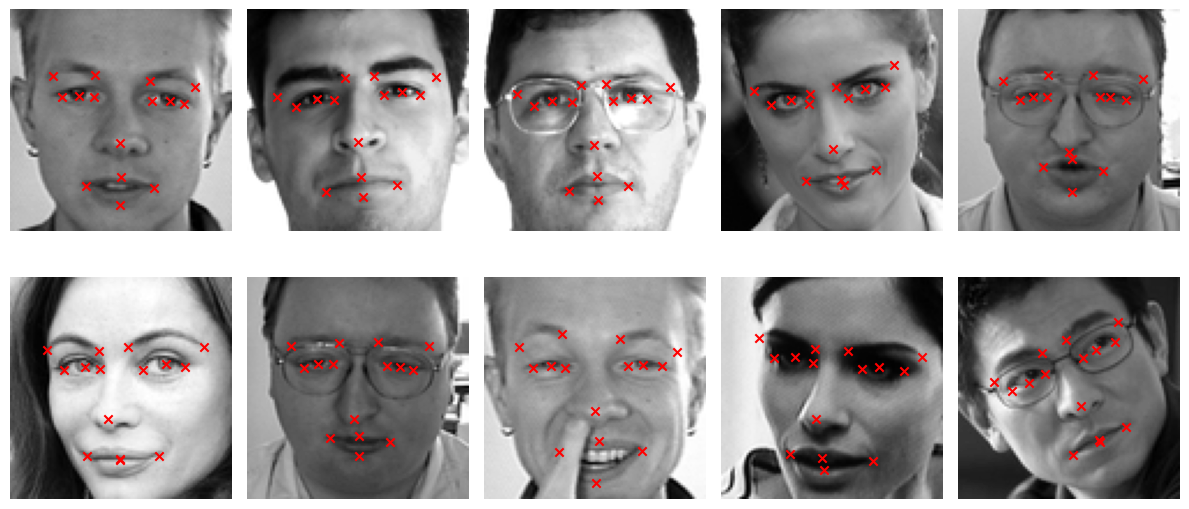

In [161]:
# load the data
data = io.loadmat("./face_landmark.mat")
images = data["images"]
landmarks = data["landmarks"]
print("im_shape:", images.shape)
print("landmarks_shape:", landmarks.shape)

# visualize a random data

np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(images))
    img = images[index]
    keypoints = landmarks[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [162]:
images.shape

(2140, 96, 96)

In [163]:
landmarks.shape  # image 당15개의 landmark

(2140, 15, 2)

In [164]:
mean = np.mean(images)
mean

121.06315

In [165]:
std = np.std(images)
std

59.070286

In [166]:
def flip_along_y(points):
    points[:, 0] = 95 - points[:, 0]
    return points

def normalize_data(image) :
    image = TF.normalize(image, mean, std)
    
    return image

def flip_data(image, landmark) :
    image = TF.to_tensor(self.images[index]).clone()
    image = TF.normalize(image, mean, std)
    landmark = torch.tensor(self.landmarks[index])
        
    # random flip
    r = random.random()  # 0 ~ 1
    if r >  0.5:  # flip
        image = TF.hflip(image)
        self.flip_along_y(landmark)
    
    return image, landmark    

def data_to_tensor(data) :
    return torch.tensor(data)

In [168]:
def l1_loss(y_true, y_pred) :
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def l2_loss(y_true, y_pred) :
    return tf.reduce_mean(tf.square(y_true - y_pred))

def cosine_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    return tf.reduce_mean(1 - tf.reduce_sum(y_true * y_pred, axis=-1))

def custom_loss(y_true, y_pred) :
    return l2_loss(y_true, y_pred) + 2*cosine_loss(y_true, y_pred)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(images, landmarks, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1284, 96, 96)
Validation set shape: (428, 96, 96)
Testing set shape: (428, 96, 96)


In [193]:
X_train, X_val, X_test = normalize_data(data_to_tensor(X_train)), normalize_data(data_to_tensor(X_val)), normalize_data(data_to_tensor(X_test))
y_train, y_val, y_test = normalize_data(data_to_tensor(y_train)), normalize_data(data_to_tensor(y_val)), normalize_data(data_to_tensor(y_test))

TypeError: Scalar tensor has no `len()`

In [191]:
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val.numpy(), dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test.numpy(), dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train.numpy(), dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val.numpy(), dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test.numpy(), dtype=tf.float32)

In [195]:
y_train = y_train.reshape(y_train.shape[0], 30, 1)
y_val = y_val.reshape(y_val.shape[0], 30, 1)
y_test = y_test.reshape(y_test.shape[0], 30, 1)

In [179]:
y_train[0]

array([[70.32252 , 39.389553],
       [33.771015, 33.437843],
       [58.755585, 39.032032],
       [76.842064, 40.94583 ],
       [39.11283 , 36.84483 ],
       [25.968592, 31.25064 ],
       [57.95531 , 28.713663],
       [79.84504 , 30.759184],
       [39.120583, 27.093185],
       [23.872154, 25.472708],
       [35.617573, 66.743965],
       [60.13255 , 90.77966 ],
       [34.826427, 82.56161 ],
       [43.644966, 85.70128 ],
       [43.987415, 90.53295 ]], dtype=float32)

In [188]:
y_train.shape

torch.Size([1284, 30, 1])

In [196]:
y_train = np.reshape(y_train, (y_train.shape[0], 15, 2))
y_train[0]

array([[70.32252 , 39.389553],
       [33.771015, 33.437843],
       [58.755585, 39.032032],
       [76.842064, 40.94583 ],
       [39.11283 , 36.84483 ],
       [25.968592, 31.25064 ],
       [57.95531 , 28.713663],
       [79.84504 , 30.759184],
       [39.120583, 27.093185],
       [23.872154, 25.472708],
       [35.617573, 66.743965],
       [60.13255 , 90.77966 ],
       [34.826427, 82.56161 ],
       [43.644966, 85.70128 ],
       [43.987415, 90.53295 ]], dtype=float32)

# Model_l1 loss

In [171]:
model = tf.keras.Sequential()

# Conv layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1), kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 1
model.add(layers.MaxPooling2D((2, 2), strides=2, ))
# Dropout layer 1
#model.add(layers.Dropout(0.25))

# Conv layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 2
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 2
#model.add(layers.Dropout(0.25))

# Conv layer 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 3
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 3
#model.add(layers.Dropout(0.25))

# Conv layer 4
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 4
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 4
#model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(64, activation='relu'))
# Dropout layer 5

# Output layer
model.add(layers.Dense(units=30, activation='relu'))

model.compile(optimizer='adam', loss=l1_loss)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, mode = 'auto', patience = 10)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])

Epoch 1/100
41/41 [==============================] - 9s 197ms/step - loss: 26.5180 - val_loss: 21.4676
Epoch 2/100
41/41 [==============================] - 8s 195ms/step - loss: 20.5777 - val_loss: 19.7612
Epoch 3/100
41/41 [==============================] - 8s 193ms/step - loss: 20.6042 - val_loss: 19.6913
Epoch 4/100
41/41 [==============================] - 8s 194ms/step - loss: 19.6537 - val_loss: 19.2845
Epoch 5/100
41/41 [==============================] - 8s 195ms/step - loss: 19.5509 - val_loss: 19.8221
Epoch 6/100
41/41 [==============================] - 8s 197ms/step - loss: 19.3651 - val_loss: 19.5947
Epoch 7/100
41/41 [==============================] - 8s 196ms/step - loss: 19.0676 - val_loss: 18.9437
Epoch 8/100
41/41 [==============================] - 8s 196ms/step - loss: 19.1859 - val_loss: 19.6408
Epoch 9/100
41/41 [==============================] - 8s 194ms/step - loss: 18.5581 - val_loss: 18.3452
Epoch 10/100
41/41 [==============================] - 8s 195ms/step - los

In [172]:
predictions = model.predict(X_test)
predictions = np.reshape(predictions, (predictions.shape[0], 15, 2))
predictions

14/14 [==============================] - 1s 53ms/step


array([[[ 0.      , 36.498833],
        [ 0.      , 37.26431 ],
        [59.60207 , 37.714485],
        ...,
        [29.481825,  0.      ],
        [ 0.      , 67.466545],
        [47.19803 , 80.562836]],

       [[ 0.      , 43.45943 ],
        [ 0.      , 37.056625],
        [64.36525 , 45.805397],
        ...,
        [36.539124,  0.      ],
        [ 0.      , 82.6701  ],
        [50.72079 , 89.98328 ]],

       [[ 0.      , 36.871407],
        [ 0.      , 37.24313 ],
        [61.177902, 39.273422],
        ...,
        [34.31586 ,  0.      ],
        [ 0.      , 74.29451 ],
        [48.637535, 82.98097 ]],

       ...,

       [[ 0.      , 36.609764],
        [ 0.      , 36.587452],
        [60.7176  , 37.14487 ],
        ...,
        [37.843815,  0.      ],
        [ 0.      , 67.37383 ],
        [49.397476, 82.122856]],

       [[ 0.      , 31.84029 ],
        [ 0.      , 32.29869 ],
        [49.84214 , 31.028307],
        ...,
        [28.341923,  0.      ],
        [ 0.      

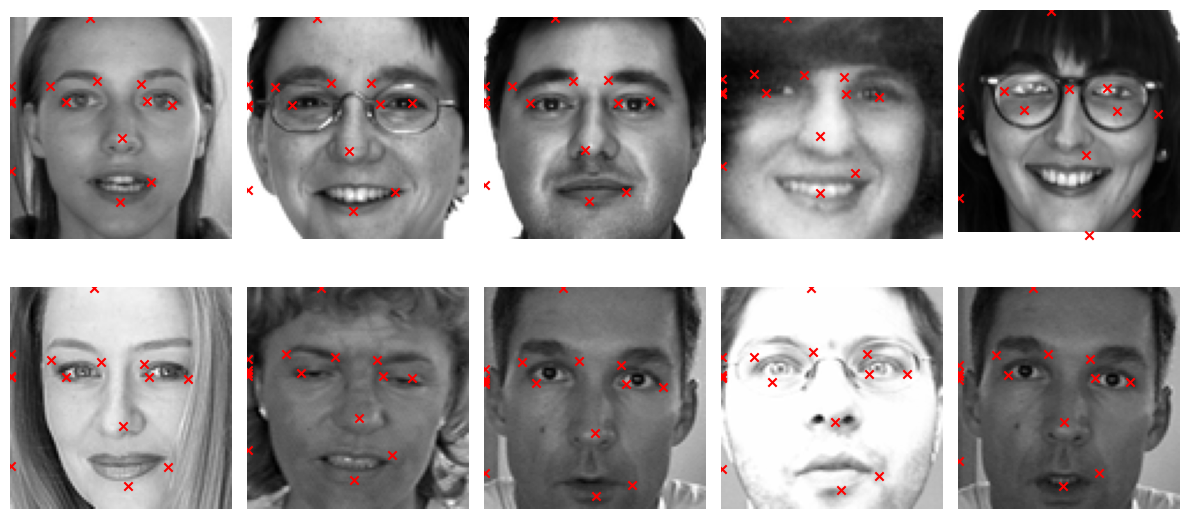

In [173]:
np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(X_test))
    img = X_test[index]
    keypoints = predictions[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [132]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 10, 10, 64)     

# Model_l2 loss

In [124]:
model = tf.keras.Sequential()

# Conv layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1), kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 1
model.add(layers.MaxPooling2D((2, 2), strides=2, ))
# Dropout layer 1
#model.add(layers.Dropout(0.25))

# Conv layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 2
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 2
#model.add(layers.Dropout(0.25))

# Conv layer 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 3
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 3
#model.add(layers.Dropout(0.25))

# Conv layer 4
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 4
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 4
#model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(64, activation='relu'))
# Dropout layer 5

# Output layer
model.add(layers.Dense(units=30, activation='relu'))

model.compile(optimizer='adam', loss=l2_loss)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, mode = 'auto', patience = 10)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])

predictions = model.predict(X_test)

Epoch 1/100
41/41 [==============================] - 9s 203ms/step - loss: 1121.1166 - val_loss: 877.2700
Epoch 2/100
14/14 [==============================] - 1s 55ms/step


In [125]:
predictions = np.reshape(predictions, (predictions.shape[0], 15, 2))
predictions

array([[[ 66.69066 ,  35.79394 ],
        [  0.      ,  36.482365],
        [ 57.330498,   0.      ],
        ...,
        [ 31.883755,  69.70882 ],
        [ 48.32242 ,  73.95194 ],
        [ 52.38833 ,  81.34437 ]],

       [[ 75.17373 ,  38.687683],
        [  0.      ,  38.28404 ],
        [ 65.15589 ,   0.      ],
        ...,
        [ 36.46429 ,  79.80493 ],
        [ 52.285564,  83.87251 ],
        [ 54.590546,  89.55905 ]],

       [[ 76.683914,  41.97664 ],
        [  0.      ,  43.257927],
        [ 66.56819 ,   0.      ],
        ...,
        [ 33.451046,  80.300285],
        [ 55.10728 ,  84.73979 ],
        [ 60.226276,  93.32346 ]],

       ...,

       [[ 75.29615 ,  39.882736],
        [  0.      ,  40.435978],
        [ 63.854076,   0.      ],
        ...,
        [ 34.18214 ,  79.84536 ],
        [ 52.8516  ,  79.68083 ],
        [ 52.300266,  87.42875 ]],

       [[ 40.983715,  20.177677],
        [  0.      ,  21.961243],
        [ 35.443832,   0.      ],
        .

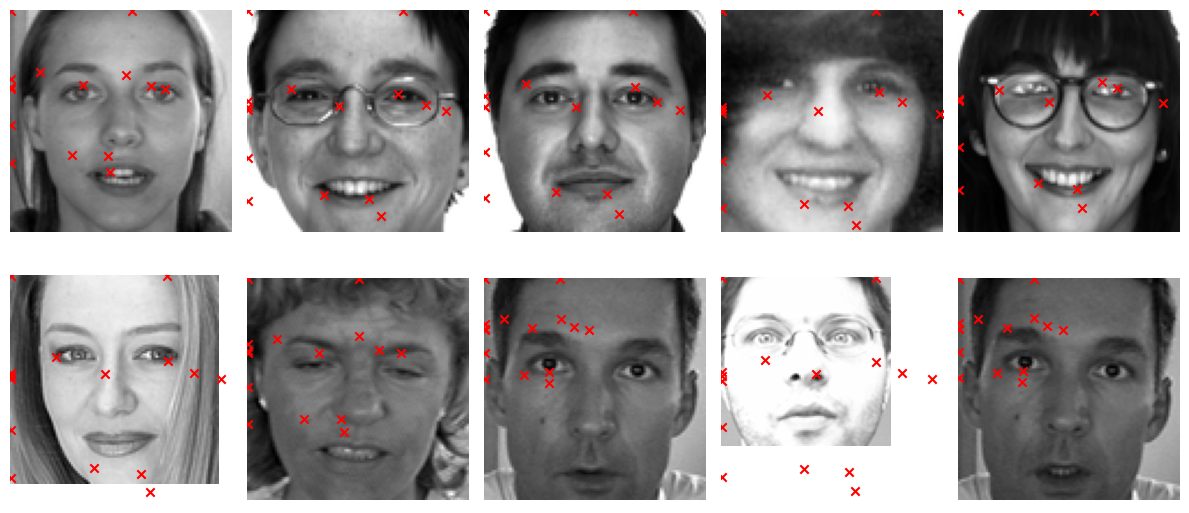

In [126]:
np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(X_test))
    img = X_test[index]
    keypoints = predictions[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model_cosine loss

In [145]:
model = tf.keras.Sequential()

# Conv layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1), kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 1
model.add(layers.MaxPooling2D((2, 2), strides=2, ))
# Dropout layer 1
#model.add(layers.Dropout(0.25))

# Conv layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 2
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 2
#model.add(layers.Dropout(0.25))

# Conv layer 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 3
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 3
#model.add(layers.Dropout(0.25))

# Conv layer 4
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 4
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 4
#model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(64, activation='relu'))
# Dropout layer 5

# Output layer
model.add(layers.Dense(units=30, activation='relu'))

model.compile(optimizer='adam', loss=cosine_loss)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, mode = 'min', patience = 10)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])

predictions = model.predict(X_test)

Epoch 1/100
41/41 [==============================] - 9s 197ms/step - loss: 1.0137 - val_loss: 0.5564
Epoch 2/100
41/41 [==============================] - 8s 193ms/step - loss: 0.3839 - val_loss: 0.2640
Epoch 3/100
41/41 [==============================] - 8s 193ms/step - loss: 0.2162 - val_loss: 0.1808
Epoch 4/100
41/41 [==============================] - 8s 192ms/step - loss: 0.1631 - val_loss: 0.1495
Epoch 5/100
41/41 [==============================] - 8s 193ms/step - loss: 0.1410 - val_loss: 0.1348
Epoch 6/100
41/41 [==============================] - 8s 194ms/step - loss: 0.1302 - val_loss: 0.1270
Epoch 7/100
41/41 [==============================] - 8s 194ms/step - loss: 0.1242 - val_loss: 0.1227
Epoch 8/100
41/41 [==============================] - 8s 192ms/step - loss: 0.1209 - val_loss: 0.1202
Epoch 9/100
41/41 [==============================] - 8s 194ms/step - loss: 0.1189 - val_loss: 0.1187
Epoch 10/100
41/41 [==============================] - 8s 192ms/step - loss: 0.1177 - val_lo

In [146]:
predictions = np.reshape(predictions, (predictions.shape[0], 15, 2))
predictions

array([[[0.3606183 , 0.20009668],
        [0.1628583 , 0.21171573],
        [0.32429636, 0.        ],
        ...,
        [0.        , 0.4203976 ],
        [0.26429   , 0.        ],
        [0.269418  , 0.46111387]],

       [[0.3606183 , 0.20009668],
        [0.1628583 , 0.21171573],
        [0.32429636, 0.        ],
        ...,
        [0.        , 0.4203976 ],
        [0.26429   , 0.        ],
        [0.269418  , 0.46111387]],

       [[0.3606183 , 0.20009668],
        [0.1628583 , 0.21171573],
        [0.32429636, 0.        ],
        ...,
        [0.        , 0.4203976 ],
        [0.26429   , 0.        ],
        [0.269418  , 0.46111387]],

       ...,

       [[0.36061826, 0.2000967 ],
        [0.1628583 , 0.21171576],
        [0.32429636, 0.        ],
        ...,
        [0.        , 0.42039767],
        [0.26429   , 0.        ],
        [0.26941803, 0.4611139 ]],

       [[0.36061826, 0.2000967 ],
        [0.1628583 , 0.21171576],
        [0.32429636, 0.        ],
        .

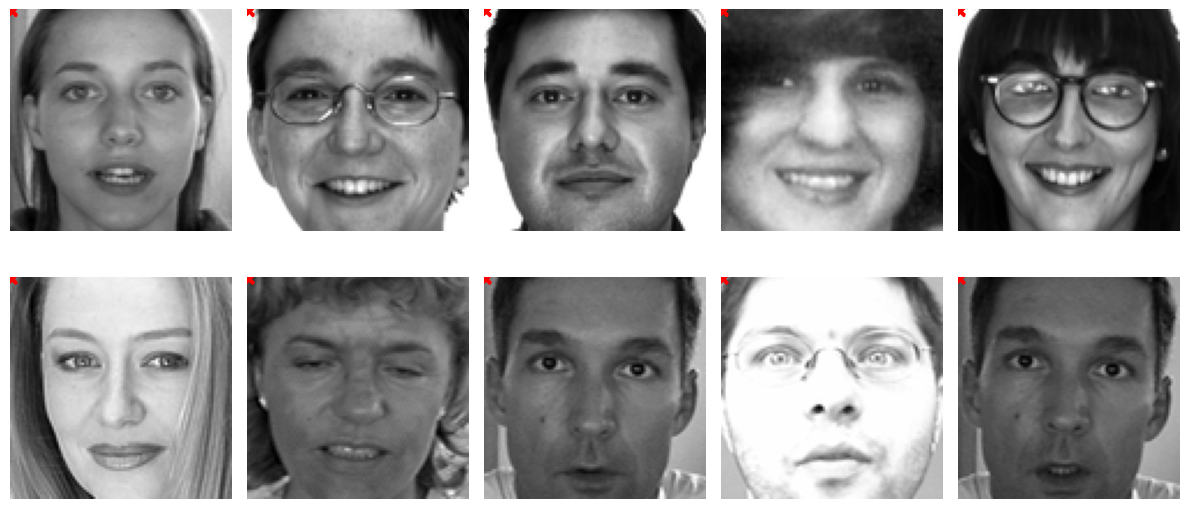

In [150]:
np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(X_test))
    img = X_test[index]
    keypoints = predictions[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model_custom loss

In [153]:
model = tf.keras.Sequential()

# Conv layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1), kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 1
model.add(layers.MaxPooling2D((2, 2), strides=2, ))
# Dropout layer 1
#model.add(layers.Dropout(0.25))

# Conv layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 2
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 2
#model.add(layers.Dropout(0.25))

# Conv layer 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 3
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 3
#model.add(layers.Dropout(0.25))

# Conv layer 4
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Max pooling layer 4
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 4
#model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(64, activation='relu'))
# Dropout layer 5

# Output layer
model.add(layers.Dense(units=30, activation='relu'))

model.compile(optimizer='adam', loss=custom_loss)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

predictions = model.predict(X_test)

Epoch 1/100
41/41 [==============================] - 9s 196ms/step - loss: 722.7386 - val_loss: 548.0237
Epoch 2/100
41/41 [==============================] - 8s 194ms/step - loss: 542.8787 - val_loss: 520.8737
Epoch 3/100
41/41 [==============================] - 8s 195ms/step - loss: 538.1233 - val_loss: 515.8842
Epoch 4/100
41/41 [==============================] - 8s 192ms/step - loss: 528.2253 - val_loss: 576.9008
Epoch 5/100
41/41 [==============================] - 8s 190ms/step - loss: 541.4085 - val_loss: 522.5676
Epoch 6/100
41/41 [==============================] - 8s 188ms/step - loss: 515.6187 - val_loss: 540.0881
Epoch 7/100
41/41 [==============================] - 8s 190ms/step - loss: 505.9607 - val_loss: 493.8173
Epoch 8/100
41/41 [==============================] - 8s 191ms/step - loss: 494.7803 - val_loss: 495.7300
Epoch 9/100
41/41 [==============================] - 8s 193ms/step - loss: 486.3361 - val_loss: 490.8141
Epoch 10/100
41/41 [==============================] - 8

In [154]:
predictions = np.reshape(predictions, (predictions.shape[0], 15, 2))
predictions

array([[[ 75.32623 ,  39.92797 ],
        [ 32.469467,  40.963196],
        [ 65.3934  ,  44.65362 ],
        ...,
        [ 31.534523,  81.87937 ],
        [ 53.571472,  80.762535],
        [ 55.293633,   0.      ]],

       [[ 90.522705,  49.142735],
        [ 40.164185,  45.314426],
        [ 79.15611 ,  50.424404],
        ...,
        [ 43.117054, 100.21612 ],
        [ 61.336346,  94.95499 ],
        [ 60.605965,   0.      ]],

       [[ 65.51509 ,  37.96254 ],
        [ 28.37567 ,  36.896515],
        [ 57.29468 ,  36.784092],
        ...,
        [ 31.698755,  73.02286 ],
        [ 48.08137 ,  69.88599 ],
        [ 47.977478,   0.      ]],

       ...,

       [[ 69.90617 ,  38.242752],
        [ 32.567226,  38.535427],
        [ 64.21701 ,  39.708805],
        ...,
        [ 38.12258 ,  79.91128 ],
        [ 53.40108 ,  71.13896 ],
        [ 54.419304,   0.      ]],

       [[ 67.433365,  39.7479  ],
        [ 31.709824,  39.71608 ],
        [ 60.09442 ,  38.97625 ],
        .

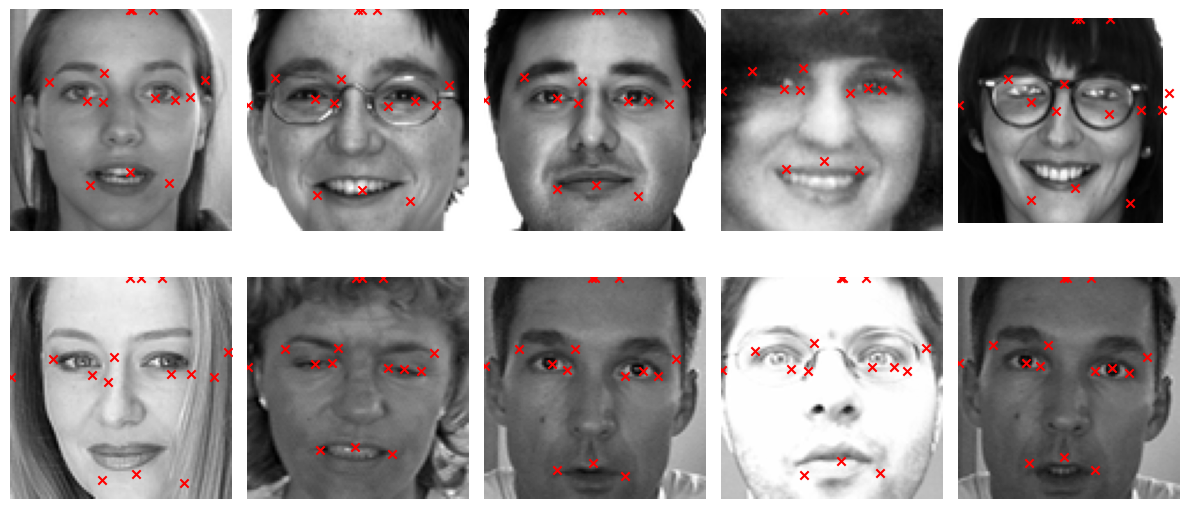

In [155]:
np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(X_test))
    img = X_test[index]
    keypoints = predictions[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model_Not Regularize

In [157]:
model = tf.keras.Sequential()

# Conv layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
# Max pooling layer 1
model.add(layers.MaxPooling2D((2, 2), strides=2, ))
# Dropout layer 1
#model.add(layers.Dropout(0.25))

# Conv layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# Max pooling layer 2
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 2
#model.add(layers.Dropout(0.25))

# Conv layer 3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer 3
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 3
#model.add(layers.Dropout(0.25))

# Conv layer 4
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer 4
model.add(layers.MaxPooling2D((2, 2), strides=2))
# Dropout layer 4
#model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(64, activation='relu'))
# Dropout layer 5

# Output layer
model.add(layers.Dense(units=30, activation='relu'))

model.compile(optimizer='adam', loss=custom_loss)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

predictions = model.predict(X_test)

Epoch 1/100
41/41 [==============================] - 8s 184ms/step - loss: 1121.8442 - val_loss: 953.2842
Epoch 2/100
41/41 [==============================] - 7s 180ms/step - loss: 958.7076 - val_loss: 943.1157
Epoch 3/100
41/41 [==============================] - 7s 177ms/step - loss: 947.3636 - val_loss: 931.6576
Epoch 4/100
41/41 [==============================] - 7s 179ms/step - loss: 915.8616 - val_loss: 919.3152
Epoch 5/100
41/41 [==============================] - 7s 176ms/step - loss: 906.3575 - val_loss: 896.9078
Epoch 6/100
41/41 [==============================] - 7s 178ms/step - loss: 890.2253 - val_loss: 883.3476
Epoch 7/100
41/41 [==============================] - 7s 182ms/step - loss: 863.3859 - val_loss: 867.2208
Epoch 8/100
41/41 [==============================] - 7s 180ms/step - loss: 859.2070 - val_loss: 856.8801
Epoch 9/100
41/41 [==============================] - 7s 178ms/step - loss: 851.3138 - val_loss: 876.7337
Epoch 10/100
41/41 [==============================] - 

In [158]:
predictions = np.reshape(predictions, (predictions.shape[0], 15, 2))
predictions

array([[[ 0.      , 39.689083],
        [26.687952, 37.489944],
        [ 0.      , 41.621883],
        ...,
        [26.850662, 70.865616],
        [46.399708, 71.0121  ],
        [47.61606 , 85.25485 ]],

       [[ 0.      , 45.394066],
        [34.963425, 42.626644],
        [ 0.      , 47.73502 ],
        ...,
        [37.62757 , 84.05678 ],
        [52.27218 , 86.33642 ],
        [57.354195, 88.07528 ]],

       [[ 0.      , 31.857159],
        [26.65591 , 30.782997],
        [ 0.      , 32.460415],
        ...,
        [26.053795, 68.79077 ],
        [41.701347, 66.12718 ],
        [41.98202 , 71.8567  ]],

       ...,

       [[ 0.      , 33.970654],
        [27.837519, 33.771416],
        [ 0.      , 34.010807],
        ...,
        [33.42278 , 70.155136],
        [44.099262, 61.184006],
        [46.185303, 74.863976]],

       [[ 0.      , 34.253628],
        [25.648518, 33.608654],
        [ 0.      , 33.747326],
        ...,
        [29.3653  , 68.077415],
        [39.602345

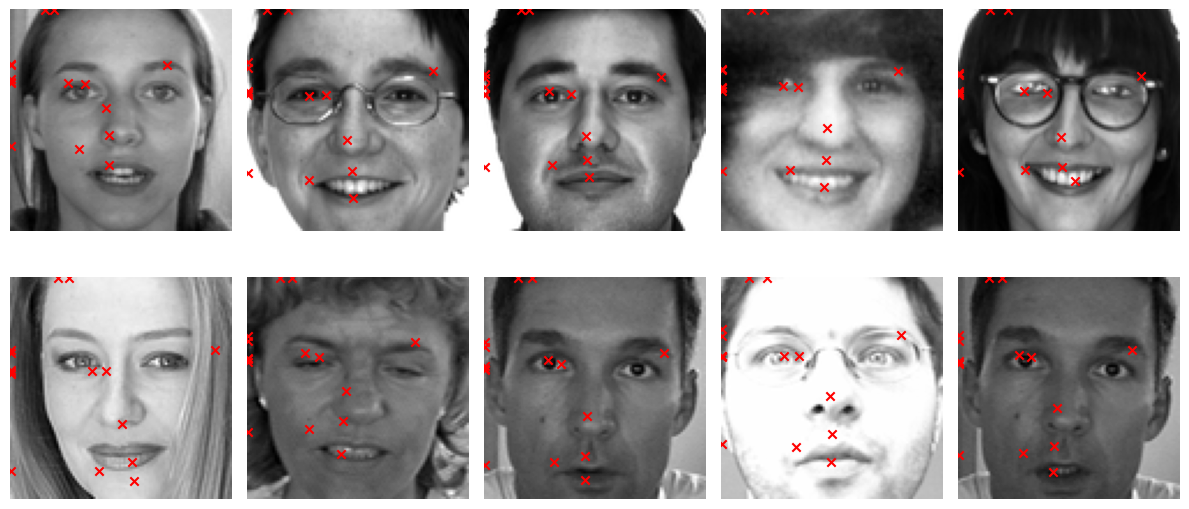

In [159]:
np.random.seed(101)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(X_test))
    img = X_test[index]
    keypoints = predictions[index]
    
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x')
    ax.axis('off')

plt.tight_layout()
plt.show()